### Creating an ensemble



Medusa has two families of methods for generating ensembles: **expansion** and **degradation**. Expansion approaches currently consist of gapfilling algorithms. Degradation approaches include random degradation (useful for benchmarking new gapfilling methods) and omics integration algorithms that constrain network (e.g. transcriptomics integration; not currently implemented).

## Expanding a network

The most common network expansion approach involving metabolic networks is algorithmic gapfilling, where the goal is to identify reactions to add to a network that allow a feasible solution. An example of this is adding a minimal number of reactions to enable biomass production in a model for an organism in a specific condition (e.g. SMILEY [1]). See the [gapfilling documentation in cobrapy](https://cobrapy.readthedocs.io/en/latest/gapfilling.html) for the formulation of this problem.

Adding the minimum number of reactions to satisfy a biological function is just one approach to the gapfilling strategy. An alternative approach is to reformulate the problem to add the minimum amount of *flux* through candidate reactions for gapfilling. This has the advantage of being an entirely continuous problem, rather than the integer problem posed by SMILEY, so the time to find a solution is usually 1-2 orders of magnitude shorter.

In `medusa`, implementations of both gapfilling strategies are available, **but we recommend the continuous approach**, which we demonstrate below.

## Input for gapfilling

The key inputs for gapfilling are a `cobra.Model` object representing the GENRE you are filling gaps in and a second `cobra.Model` object containing reactions that form a *universal reaction database* (sometimes called a *universal reaction bag*). Additionally, context-specific information, such as the environmental conditions in which a phenotype was observed, may be needed to constrain the model during gapfilling.

Let's use test data available in `medusa` for gapfilling. The approach we'll take to generate multiple solutions involves iteratively gapfilling across multiple media conditions to generate a single gapfilled model. We repeat the process with the original model but with a shuffled version of the media conditions (changing the order in which media conditions are used during gapfilling), each time generating a new solution. You can see examples of this approach in Biggs & Papin [2] and Medlock & Papin [3].

In [1]:
# Load the test model for Staphylococcus aureus, originally generated with ModelSEED
import medusa
from medusa.test import create_test_model
model = create_test_model('Saureus_seed')

# Load the biolog data from Plata et al., Nature 2014
from medusa.test import load_biolog_plata
biolog_base_composition, biolog_base_dict, biolog_thresholded = load_biolog_plata()
biolog_base_composition


,Name,ID
0,H2O,cpd00001_e
1,O2,cpd00007_e
2,Phosphate,cpd00009_e
3,CO2,cpd00011_e
4,NH3,cpd00013_e
5,Mn2+,cpd00030_e
6,Zn2+,cpd00034_e
7,Sulfate,cpd00048_e
8,Cu2+,cpd00058_e
9,Ca2+,cpd00063_e


Here, `biolog_base_composition` describes the media components that are present in every biolog condition (Note: if you are using these data for your own purposes, keep in mind that we added Heme and H2S2O3 due to common issues encountered in models. These are not actually in the biolog medium).

The `biolog_base_dict` is a dictionary version of this, which we'll use as direct input to the models as part of `model.medium`

In [3]:
biolog_base_dict

{'cpd00001_e': 1000,
 'cpd00007_e': 1000,
 'cpd00009_e': 1000,
 'cpd00011_e': 1000,
 'cpd00013_e': 1000,
 'cpd00028_e': 1000,
 'cpd00030_e': 1000,
 'cpd00034_e': 1000,
 'cpd00048_e': 1000,
 'cpd00058_e': 1000,
 'cpd00063_e': 1000,
 'cpd00067_e': 1000,
 'cpd00099_e': 1000,
 'cpd00149_e': 1000,
 'cpd00205_e': 1000,
 'cpd00254_e': 1000,
 'cpd00268_e': 1000,
 'cpd00971_e': 1000,
 'cpd10515_e': 1000,
 'cpd10516_e': 1000}

The actual growth/no growth data is in `biolog_thresholded`, which is a pandas `DataFrame` with organism species/genus as rows, and biolog media conditions as columns represented by the ModelSEED metabolite ID for the single carbon/nitrogen source present. The original source of these data is [4]; there, you can find the non-thresholded values if curious. Here, we've thresholded the growth data using the same threshold reported in the paper (>=10 relative units of tetrazolium dye).

In [4]:
# Just inspect the first 5 species
biolog_thresholded.head(5)

,cpd11594_e,cpd00179_e,cpd00794_e,cpd03845_e,cpd05158_e,cpd00076_e,cpd01133_e,cpd00382_e,cpd00208_e,cpd03198_e,...,cpd00024_e,cpd00386_e,cpd00130_e,cpd00281_e,cpd03561_e,cpd00094_e,cpd00142_e,cpd00141_e,cpd00029_e,cpd00047_e
Staphylococcus aureus,True,True,True,False,True,True,False,False,True,False,...,True,False,True,False,True,True,True,True,True,True
Ralstonia solanacearum,False,False,True,False,False,True,False,False,False,False,...,True,False,True,True,False,False,False,True,True,True
Staphylococcus haemolyticus,True,True,True,False,False,True,False,False,True,False,...,True,False,False,False,True,True,True,False,True,True
Bacillus pumilus,True,False,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
Corynebacterium glutamicum,True,True,False,False,False,True,False,False,False,False,...,False,False,True,True,True,True,True,True,True,False


Now we'll extract the positive growth conditions for the species we're interested in (*Staphylococcus aureus*)

In [5]:
test_mod_pheno = biolog_thresholded.loc['Staphylococcus aureus']
test_mod_pheno = list(test_mod_pheno[test_mod_pheno == True].index)
test_mod_pheno

['cpd11594_e',
 'cpd00179_e',
 'cpd00794_e',
 'cpd05158_e',
 'cpd00076_e',
 'cpd00208_e',
 'cpd15584_e',
 'cpd00122_e',
 'cpd00492_e',
 'cpd00232_e',
 'cpd19001_e',
 'cpd00138_e',
 'cpd00082_e',
 'cpd00709_e',
 'cpd00396_e',
 'cpd00246_e',
 'cpd00314_e',
 'cpd01307_e',
 'cpd00100_e',
 'cpd00079_e',
 'cpd00072_e',
 'cpd00320_e',
 'cpd00035_e',
 'cpd00051_e',
 'cpd00041_e',
 'cpd00023_e',
 'cpd00119_e',
 'cpd01293_e',
 'cpd00054_e',
 'cpd00222_e',
 'cpd05264_e',
 'cpd00159_e',
 'cpd00024_e',
 'cpd00130_e',
 'cpd03561_e',
 'cpd00094_e',
 'cpd00142_e',
 'cpd00141_e',
 'cpd00029_e',
 'cpd00047_e']

In order to gapfill this model, we have to make sure that the biolog media components are in the model, and that there are exchange reactions for each of these metabolites. To make this process more convenient, we'll load the universal reaction database now, which we will also use later in the process. The universal model is large, and the `load_universal_modelseed` does some extra processing of the model, so loading it may take a few minutes. First we'll check for changes that need to be made:

In [6]:
# load the universal reaction database
from medusa.test import load_universal_modelseed
from cobra.core import Reaction
universal = load_universal_modelseed()

# check for biolog base components in the model and record
# the metabolites/exchanges that need to be added
add_mets = []
add_exchanges = []
for met in list(biolog_base_dict.keys()):
    try:
        model.metabolites.get_by_id(met)
    except:
        print('no '+met)
        add_met = universal.metabolites.get_by_id(met).copy()
        add_mets.append(add_met)

model.add_metabolites(add_mets)

for met in list(biolog_base_dict.keys()):
    # Search for exchange reactions
    try:
        model.reactions.get_by_id('EX_'+met)
    except:
        add_met = model.metabolites.get_by_id(met)
        ex_rxn = Reaction('EX_' + met)
        ex_rxn.name = "Exchange reaction for " + met
        ex_rxn.lower_bound = -1000
        ex_rxn.upper_bound = 1000
        ex_rxn.add_metabolites({add_met:-1})
        add_exchanges.append(ex_rxn)

model.add_reactions(add_exchanges)


no cpd00013_e


Next, we need to do the same for the single carbon/nitrogen sources in the biolog data. Since we know the organism grew in each of these conditions, we know the metabolite must have been transported, so we will manually add a transporter now to speed the process up (without this step, a suitable transporter would be found during gapfilling).

In [7]:
# Find metabolites from the biolog data that are missing in the test model
# and add them from the universal
missing_mets = []
missing_exchanges = []
media_dicts = {}
for met_id in test_mod_pheno:
    try:
        model.metabolites.get_by_id(met_id)
    except:
        print(met_id + " was not in model, adding met and exchange reaction")
        met = universal.metabolites.get_by_id(met_id).copy()
        missing_mets.append(met)
        ex_rxn = Reaction('EX_' + met_id)
        ex_rxn.name = "Exchange reaction for " + met_id
        ex_rxn.lower_bound = -1000
        ex_rxn.upper_bound = 1000
        ex_rxn.add_metabolites({met:-1})
        missing_exchanges.append(ex_rxn)
    media_dicts[met_id] = biolog_base_dict.copy()
    media_dicts[met_id] = {'EX_'+k:v for k,v in media_dicts[met_id].items()}
    media_dicts[met_id]['EX_'+met_id] = 1000
model.add_metabolites(missing_mets)
model.add_reactions(missing_exchanges)

# identify transporters for each biolog component in the universal model
# and pick one that will enable transport in the gapfilling problem.
transporters_in_universal = [rxn for rxn in universal.reactions if len(rxn.compartments)>1]
for met in media_dicts.keys():
    metabolite = model.metabolites.get_by_id(met)
    base_met_id = met.split('_')[0]
    rxns_with_metabolite = metabolite.reactions
    transport = False
    for rxn in rxns_with_metabolite:
        metabolites = [met_in_rxn.id for met_in_rxn in rxn.metabolites]
        if (base_met_id+'_e' in metabolites and base_met_id+'_c' in metabolites):
            transport = True

    pick_transporter = {}
    if not transport:
        print("missing transporter for " + metabolite.name)
        for rxn in transporters_in_universal:
            metabolites = [met_in_rxn.id for met_in_rxn in rxn.metabolites]
            if (base_met_id+'_e' in metabolites and base_met_id+'_c' in metabolites):
                pick_transporter[met] = rxn.id

# Add the transporters to the model
transporters_to_add = list(pick_transporter.values())
transporter_list = []
for rxn in transporters_to_add:
    transporter_list.append(universal.reactions.get_by_id(rxn).copy())
model.add_reactions(transporter_list)

# remove the added transporters from the universal model
universal.remove_reactions([universal.reactions.get_by_id(rxn) for rxn in transporters_to_add])


cpd11594_e was not in model, adding met and exchange reaction
cpd05158_e was not in model, adding met and exchange reaction
cpd15584_e was not in model, adding met and exchange reaction
cpd00492_e was not in model, adding met and exchange reaction
cpd00232_e was not in model, adding met and exchange reaction
cpd19001_e was not in model, adding met and exchange reaction
cpd00709_e was not in model, adding met and exchange reaction
cpd00396_e was not in model, adding met and exchange reaction
cpd01307_e was not in model, adding met and exchange reaction
cpd00079_e was not in model, adding met and exchange reaction
cpd00072_e was not in model, adding met and exchange reaction
cpd00320_e was not in model, adding met and exchange reaction
cpd01293_e was not in model, adding met and exchange reaction
cpd05264_e was not in model, adding met and exchange reaction
cpd03561_e was not in model, adding met and exchange reaction
cpd00094_e was not in model, adding met and exchange reaction
cpd00142

Now, let's fill some gaps using the `iterative_gapfill_from_binary_phenotypes` function. For simplicity, we'll just take the first 5 conditions and perform gapfilling for 10 cycles, which should yield an ensemble with 10 members. We set `lower_bound = 0.05`, which requires that the model produces 0.05 units of flux through the previous objective function (here, biomass production) which is now set as a constraint (i.e. v<sub>bm</sub> >= 0.05). `inclusion_threshold` is the amount of flux through a reaction required to include it in the gapfill solution, which is necessary because of the limits of numerical precision. Generally a small number (e.g. < 1E-8) is a good choice. However, some gapfill solutions may have reactions with non-zero flux in ranges lower than this; if this occurs, Medusa will raise an error letting you know that it failed to validate the gapfill solution, and that you should try lowering the threshold.

In [8]:
from medusa.reconstruct.expand import iterative_gapfill_from_binary_phenotypes
# select a subset of the biolog conditions to perform gapfilling with
sources = list(media_dicts.keys())
sub_dict = {sources[0]:media_dicts[sources[0]],
           sources[1]:media_dicts[sources[1]],
           sources[2]:media_dicts[sources[2]],
           sources[3]:media_dicts[sources[3]],
           sources[4]:media_dicts[sources[4]]}

num_cycles = 10
lower_bound = 0.05
flux_cutoff = 1E-10
ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,sub_dict,num_cycles,\
                                     lower_bound=lower_bound,\
                                     inclusion_threshold=1E-10,\
                                     exchange_reactions=False,\
                                     demand_reactions=False,\
                                     exchange_prefix='EX')

Constraining lower bound for bio1
starting cycle number 0
starting cycle number 1
starting cycle number 2
starting cycle number 3
starting cycle number 4
starting cycle number 5
starting cycle number 6
starting cycle number 7
starting cycle number 8
starting cycle number 9
building features...
updating members...


In [9]:
print(len(ensemble.members))
print(ensemble.members)

10
[<Member Staphylococcus aureus_gapfilled_7 at 0x7f5f56997048>, <Member Staphylococcus aureus_gapfilled_3 at 0x7f5f56994048>, <Member Staphylococcus aureus_gapfilled_4 at 0x7f5f56a0cb38>, <Member Staphylococcus aureus_gapfilled_8 at 0x7f5f56a0cac8>, <Member Staphylococcus aureus_gapfilled_5 at 0x7f5f56a0c9e8>, <Member Staphylococcus aureus_gapfilled_0 at 0x7f5f56a0ca20>, <Member Staphylococcus aureus_gapfilled_1 at 0x7f5f56a0c9b0>, <Member Staphylococcus aureus_gapfilled_6 at 0x7f5f56a0ca58>, <Member Staphylococcus aureus_gapfilled_2 at 0x7f5f56a0c860>, <Member Staphylococcus aureus_gapfilled_9 at 0x7f5f56a0c908>]


In [10]:
# Check out the features that vary across the ensemble
print(len(ensemble.features))
print([feature.base_component.id for feature in ensemble.features])

76
['rxn00957_c', 'rxn00957_c', 'rxn01072_c', 'rxn01072_c', 'rxn08933_c', 'rxn08933_c', 'rxn10153_c', 'rxn10153_c', 'rxn12060_c', 'rxn12060_c', 'rxn01134_c', 'rxn01134_c', 'rxn08126_c', 'rxn08126_c', 'rxn01014_c', 'rxn01014_c', 'rxn07759_c', 'rxn07759_c', 'rxn13141_c', 'rxn13141_c', 'rxn38867_c', 'rxn38867_c', 'rxn01359_c', 'rxn01359_c', 'rxn01361_c', 'rxn01361_c', 'rxn12204_c', 'rxn12204_c', 'rxn02929_c', 'rxn02929_c', 'rxn07763_c', 'rxn07763_c', 'rxn00958_c', 'rxn00958_c', 'rxn02928_c', 'rxn02928_c', 'rxn00693_c', 'rxn00693_c', 'rxn07757_c', 'rxn07757_c', 'rxn09655_c', 'rxn09655_c', 'rxn00704_c', 'rxn00704_c', 'rxn07765_c', 'rxn07765_c', 'rxn08445_c', 'rxn08445_c', 'rxn10967_c', 'rxn10967_c', 'rxn00705_c', 'rxn00705_c', 'rxn08335_c', 'rxn08335_c', 'rxn09468_c', 'rxn09468_c', 'rxn01360_c', 'rxn01360_c', 'rxn38855_c', 'rxn38855_c', 'rxn00605_c', 'rxn00605_c', 'rxn12215_c', 'rxn12215_c', 'rxn00916_c', 'rxn00916_c', 'rxn01547_c', 'rxn01547_c', 'rxn00917_c', 'rxn00917_c', 'rxn36697_c', 'r

## Degrading a network

Coming here soon.

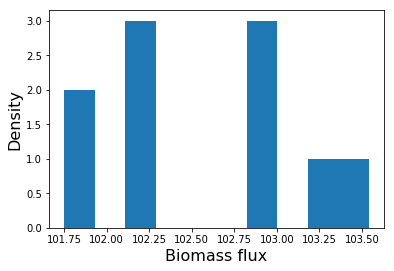

# References

**[1]: Reed et al.**, "Systems approach to refining genome annotation", *PNAS* 2006

**[2]: Biggs & Papin**, "Managing uncertainty in metabolic network structure and improving predictions using EnsembleFBA", *PLoS Computational Biology* 2017

**[3]: Medlock & Papin**, "Guiding the refinement of biochemical knowledgebases with ensembles of metabolic networks and semi-supervised learning", *BioRxiv* 2018

**[4]: Plata et al.**, "Long-term phenotypic evolution of bacteria", *Nature* 2015